## **Project Description –Image classification using CNNs in KerasData**

### **Description**

This is a dataset  of  images of  plant seedlings at various stages of  grown.  Each image has a filename has its unique  id.  The  dataset  comprises  12  plant  species.  The  goal  of  the  project  is  to  create  a  classifier  capable  of  determining  a plant's species from a photo.

### **Dataset**

The dataset can be download from Olympus.
The data file names are:•images.npy•Label.csvThe original files are from Kaggle. Due to the large volume of data, the images were converted to images.npy file and the labels are  also  put  into  the  Labels.csv.  

## **Importing the necessary libraries**

In [1]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## **Reading the Dataset**

In [2]:
# Mount Google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the image file of the dataset
images = np.load('/content/drive/MyDrive/images.npy')

# Load the labels file of the dataset
labels = pd.read_csv('/content/drive/MyDrive/Labels.csv')

## **Overview of the Dataset**

In [4]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)



#### **Observation**
There are 4750 RGB images of shape 128 x 128 X 3, each image having 3 channels.

### **Plotting images using OpenCV and matplotlib**

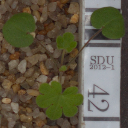

In [5]:
cv2_imshow(images[18])

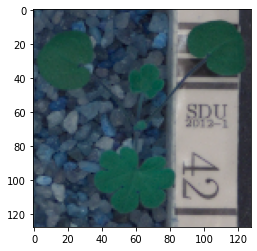

In [6]:
plt.imshow(images[18])

#### **Observation**

Images are being shown in different colors when plotted with openCV and matplotlib. OpenCV reads images in BGR format and this shows that the given numpy arrays were generated from the original images using OpenCV.

Converting these BGR images to RGB images to interpret easily.

In [7]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

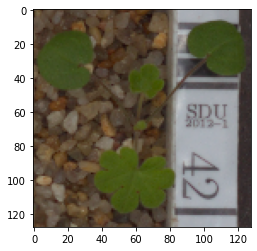

In [8]:
plt.imshow(images[18])

### **Exploratory Data Analysis**

In [21]:
def plot_images(images,labels):
  num_classes=12                                                                  # Number of Classes
  categories=np.unique(labels)   
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 5                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(15, 18))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image 
          ax.set_title(keys[random_index])
  plt.show()

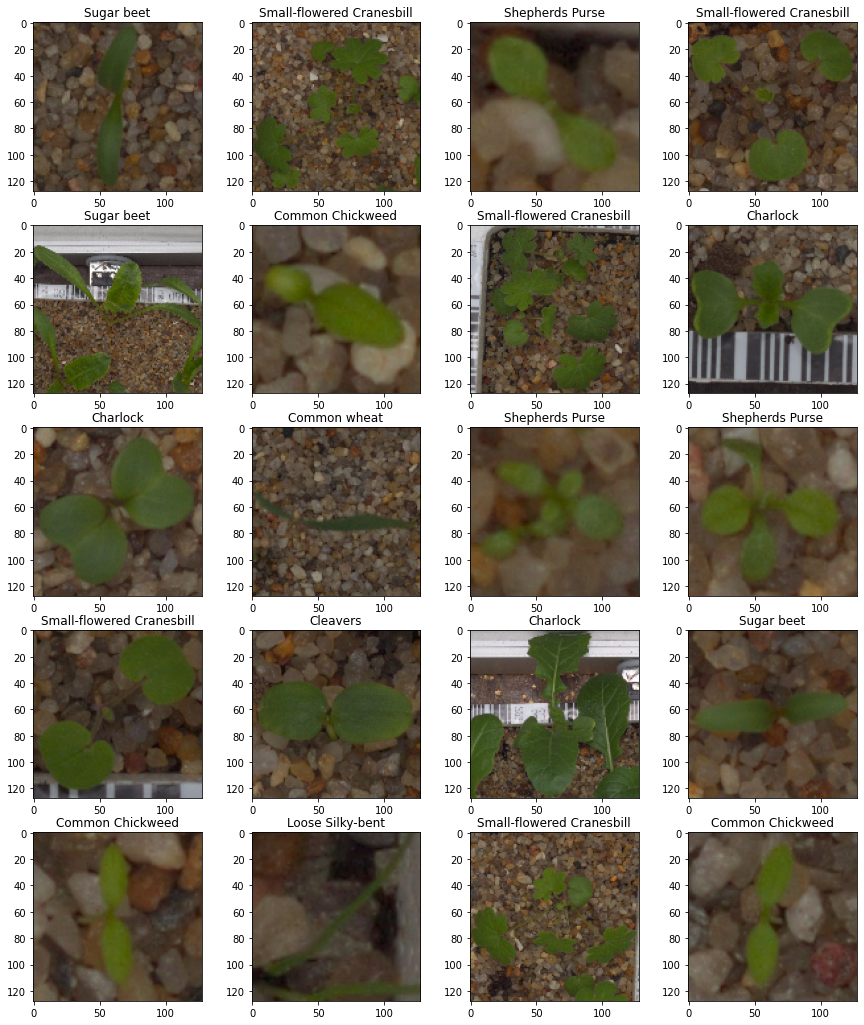

In [22]:
plot_images(images,labels)

#### **Observation**

Some of the images are plotted above. We observe that

* All images are of the same size, 128*128 pixels. Since the size is same its easy to give the these images as input for any model. 
* Some of the pictures are blurred and not much recognizable. For example, Shepherd's Purse (1st and 3rd row) is not clear. Blurrred images won't have defined edges and may result in miscalssification.
* Some plants have thin leaves and cannot be distinguished from the background. For example, the leaves of Loose Silky-bent can be hardly seen (second picture in last row)
* Some weeds have similar leaf structure which might also lead to misclassification. For example, Loose Silky-bent and Wheat have similar thin and long leaves.


### **Checking for Data Imbalance**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

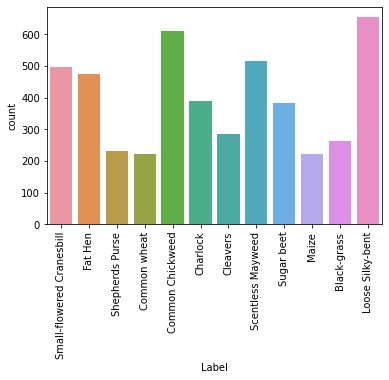

In [ ]:
sns.countplot(labels['Label'])
plt.xticks(rotation='vertical')

#### **Observations**

The data is not balanced. plant 11 (Loose Silky-bent) and plant 4 (Common chickweed) have maximum number of images, around 600. While plants 2,3,6, 9 and 10 have the least number of images, between 200 - 300. Data Augmentation might help us in dealing with class imbalance when we make our model.

### **Resizing images**

As the images are large we need to decrease the size from 128 to 64 as it can be computationally expensive for larger images

In [23]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)  
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

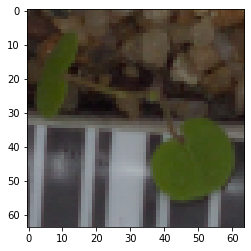

In [25]:
plt.imshow(images_decreased[10])

#### **Observation**

The resizing of the images is done to 64 * 64 because 128*128 can be computationally expensive. 

### **Visualizing the images using Gaussian Blur**

Reducing noise in the images using Gaussian Blur

In [28]:
images_gb=[]
for i in range(len(images_decreased)):
  images_gb.append(cv2.GaussianBlur(images_decreased[i], ksize =(3,3),sigmaX =  0))

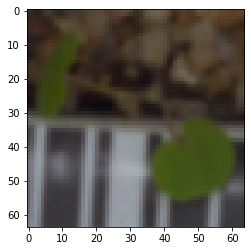

In [29]:
plt.imshow(images_gb[10])

#### **Observation**

Gaussian Blur has removed some of the irrevelant information from the image which but the image is slightly less sharper now.

### **Splitting the Dataset**

10% of data will be used for testing, 10% for validation and 80% for training.
Train_test_split() function from scikit-learn will split the dataset into three parts, train,test and validation.

In [37]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [38]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 128, 128, 3) (3847, 1)
(428, 128, 128, 3) (428, 1)
(475, 128, 128, 3) (475, 1)


#### **Observation**

Here we are maintaining the original size of the images for Transfer Learning and for other models that we will build. 

In [39]:
from sklearn.model_selection import train_test_split
X_temp_64, X_test_64, y_temp_64, y_test_64 = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)
X_train_64, X_val_64, y_train_64, y_val_64 = train_test_split(X_temp_64,y_temp_64 , test_size=0.1, random_state=42,stratify=y_temp_64)

In [40]:
print(X_train_64.shape,y_train_64.shape)
print(X_val_64.shape,y_val_64.shape)
print(X_test_64.shape,y_test_64.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


#### **Observation**

We have 64* 64 train, validation and test data as well as 128*128 can be computationally expensive. 

### **Making Data Compatible**

This can be done by
1. Encoding the target variable
2. Normalizing the values

**Encoding the target values**

In [41]:
# Convert labels from names to one hot vectors for 128 * 128
# Encoding will be done using labelBinarizer. 

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

In [42]:
# Convert labels from names to one hot vectors for 64 * 64
# Encoding will be done using labelBinarizer. 

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded_64 = enc.fit_transform(y_train_64)
y_val_encoded_64=enc.transform(y_val_64)
y_test_encoded_64=enc.transform(y_test_64)

### **Data Normalization**

Dividing the image pixel values by 255 to standardize the values so that it in 0 - 1 range

In [43]:
# Normalizing the image pixels for 128 * 128
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

In [44]:
# Normalizing the image pixels for 64 * 64
X_train64_normalized = X_train_64.astype('float32')/255.0
X_val64_normalized = X_val_64.astype('float32')/255.0
X_test64_normalized = X_test_64.astype('float32')/255.0

## **Model Building - CNN**

## **Model 1 - CNN model on 64 size images**

In [45]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [46]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [47]:
# Intializing a sequential model
model1 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model1.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))
# Adding max pooling to reduce the size of output of first conv layer
model1.add(MaxPooling2D((2, 2), padding = 'same'))

model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

model1.add(Conv2D(16, (3, 3), activation='relu', padding="same"))

# flattening the output of the conv layer to make it ready for creating dense connections
model1.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.25))

model1.add(Dense(16, activation='relu'))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem  
model1.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
opt = SGD(learning_rate=0.01, momentum=0.9)

# Compile model
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 16)        4624      
                                                                 
 flatten (Flatten)           (None, 4096)              0

In [48]:
history_1 = model1.fit(
            X_train64_normalized, y_train_encoded_64,
            epochs=15,
            validation_data=(X_val64_normalized,y_val_encoded_64),
            batch_size=32,
            verbose=2
)

Epoch 1/15
121/121 - 29s - loss: 2.4392 - accuracy: 0.1305 - val_loss: 2.4196 - val_accuracy: 0.1379 - 29s/epoch - 243ms/step
Epoch 2/15
121/121 - 29s - loss: 2.4199 - accuracy: 0.1367 - val_loss: 2.4170 - val_accuracy: 0.1425 - 29s/epoch - 238ms/step
Epoch 3/15
121/121 - 29s - loss: 2.4145 - accuracy: 0.1391 - val_loss: 2.4126 - val_accuracy: 0.1285 - 29s/epoch - 239ms/step
Epoch 4/15
121/121 - 28s - loss: 2.3881 - accuracy: 0.1591 - val_loss: 2.3637 - val_accuracy: 0.2079 - 28s/epoch - 232ms/step
Epoch 5/15
121/121 - 28s - loss: 2.2548 - accuracy: 0.2352 - val_loss: 2.2096 - val_accuracy: 0.2967 - 28s/epoch - 231ms/step
Epoch 6/15
121/121 - 29s - loss: 1.9510 - accuracy: 0.3286 - val_loss: 1.6832 - val_accuracy: 0.4065 - 29s/epoch - 241ms/step
Epoch 7/15
121/121 - 27s - loss: 1.7779 - accuracy: 0.3712 - val_loss: 1.6728 - val_accuracy: 0.4065 - 27s/epoch - 227ms/step
Epoch 8/15
121/121 - 29s - loss: 1.6331 - accuracy: 0.4130 - val_loss: 1.4499 - val_accuracy: 0.4720 - 29s/epoch - 239

#### **Observation**

The model accuracy is not very high and has reached upto 0.566 on training data and 0.61 on validation data. Its not a high accuracy but its not overfitting as the accuracy on both datasets is not far apart and the accuracy achieved on training data is lesser.

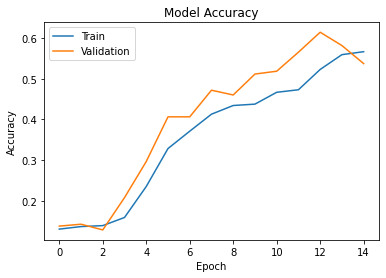

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
accuracy = model1.evaluate(X_test64_normalized, y_test_encoded_64, verbose=2)

15/15 - 1s - loss: 1.2146 - accuracy: 0.5432 - 876ms/epoch - 58ms/step


#### **Observation**

Test dataset also reached an accuracy of 0.54 on test data set which is close to the accuracy achieved on training data. This shows that the model is not overfitting on training data but a lot of misclassifications are being made which is why the accuracy is low.

We will plot the confusion matrix to check which plants are best classified and which are worst classified.

In [49]:
# Here we would get the output as probablities for each category
y_pred1=model1.predict(X_test64_normalized)

**Confusion Matrix**

The Confusion matrix expects categorical data as input. However, y_test_encoded is an encoded value, whereas y_pred1 has probabilities. So,we must retrieve the categorical values from the encoded values.
We will use the argmax() function to obtain the maximum value over each category on both y_test_encoded and y_pred1 and obtain their respective classes.

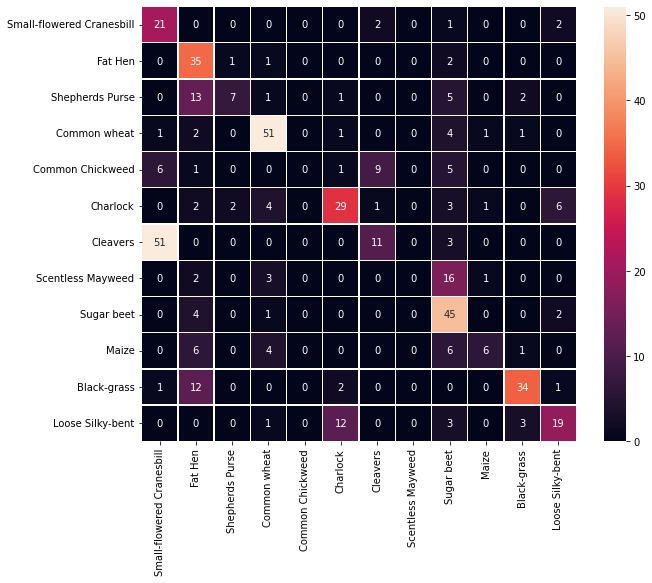

In [50]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred1,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)
CATEGORIES= ["Small-flowered Cranesbill", "Fat Hen","Shepherds Purse", "Common wheat", "Common Chickweed","Charlock", "Cleavers", "Scentless Mayweed", "Sugar beet", "Maize", "Black-grass", "Loose Silky-bent"]
# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    xticklabels=CATEGORIES,
    yticklabels=CATEGORIES,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()




#### **Observation**

As we can see 'Common Chickweed' - claas 4 and 'Scentless Mayweed' - class 7 are not being classified at all. Also the relevant classification of of classes 2, 6 and 9 is very low.

In [51]:
y_test_pred_1 = model1.predict(X_test64_normalized)
y_test_pred_classes_1 = np.argmax(y_test_pred_1, axis=1)

In [52]:

from sklearn.metrics import accuracy_score, confusion_matrix

normal_y_test1 = np.argmax(y_test_encoded_64, axis=1)

In [53]:
from sklearn.metrics import classification_report
print(classification_report((normal_y_test1), y_test_pred_classes_1))

              precision    recall  f1-score   support

           0       0.26      0.81      0.40        26
           1       0.45      0.90      0.60        39
           2       0.70      0.24      0.36        29
           3       0.77      0.84      0.80        61
           4       0.00      0.00      0.00        22
           5       0.63      0.60      0.62        48
           6       0.48      0.17      0.25        65
           7       0.00      0.00      0.00        22
           8       0.48      0.87      0.62        52
           9       0.67      0.26      0.38        23
          10       0.83      0.68      0.75        50
          11       0.63      0.50      0.56        38

    accuracy                           0.54       475
   macro avg       0.49      0.49      0.44       475
weighted avg       0.55      0.54      0.50       475



#### **Observation**

Classification Report for each class

Precision: precision is the fraction of relevant instances among the retrieved instances.

Recall: recall is the fraction of relevant instances that were retrieved.

F1 score: The F1 score is the harmonic mean of precision and recall, reaching its optimal value at 1 and its worst value at 0.

The recall score of class 0, 1, 3 and 8 are good. For other models it is quite low. The precision and F1 scores are low for this model.

## **Model - 2 with 128 pixel images**

Checking the performance of the model using 128 * 128 images. This will be computationally expensive but since some of the images are not clear and since some of the classes look similar, bigger images can help distinguish

In [55]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [56]:
# Intializing a sequential model
model2 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(128, 128, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))

model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))

model2.add(Conv2D(16, (3, 3), activation='relu', padding="same"))

# flattening the output of the conv layer to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.25))

model2.add(Dense(16, activation='relu'))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem  
model2.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
opt = SGD(learning_rate=0.01, momentum=0.9)
#opt=Adam()
# Compile model
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 flatten (Flatten)           (None, 16384)             0

#### **Observation**

128*128 images have exponentially increased the trainable parameters to 549932

In [57]:
history_2 = model2.fit(
            X_train_normalized, y_train_encoded,
            epochs=15,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/15
121/121 - 123s - loss: 2.4404 - accuracy: 0.1323 - val_loss: 2.4192 - val_accuracy: 0.1379 - 123s/epoch - 1s/step
Epoch 2/15
121/121 - 117s - loss: 2.4203 - accuracy: 0.1336 - val_loss: 2.4178 - val_accuracy: 0.1285 - 117s/epoch - 969ms/step
Epoch 3/15
121/121 - 113s - loss: 2.4185 - accuracy: 0.1383 - val_loss: 2.4165 - val_accuracy: 0.1379 - 113s/epoch - 933ms/step
Epoch 4/15
121/121 - 112s - loss: 2.4139 - accuracy: 0.1437 - val_loss: 2.4167 - val_accuracy: 0.1379 - 112s/epoch - 922ms/step
Epoch 5/15
121/121 - 113s - loss: 2.3919 - accuracy: 0.1573 - val_loss: 2.3504 - val_accuracy: 0.1822 - 113s/epoch - 935ms/step
Epoch 6/15
121/121 - 110s - loss: 2.4165 - accuracy: 0.1385 - val_loss: 2.3860 - val_accuracy: 0.2079 - 110s/epoch - 905ms/step
Epoch 7/15
121/121 - 109s - loss: 2.2836 - accuracy: 0.2181 - val_loss: 2.0421 - val_accuracy: 0.3388 - 109s/epoch - 904ms/step
Epoch 8/15
121/121 - 110s - loss: 2.0424 - accuracy: 0.2937 - val_loss: 1.7595 - val_accuracy: 0.3294 - 110

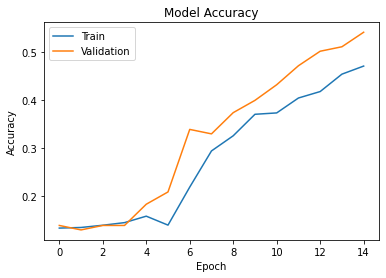

In [59]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### **Observation**

The accuracy of the model is much lower than the earlier model. Let's check the test data accuracy score and class wise scores using confusion matrix and classification report.

In [60]:
# Here we would get the output as probablities for each category
y_pred2=model2.predict(X_test_normalized)

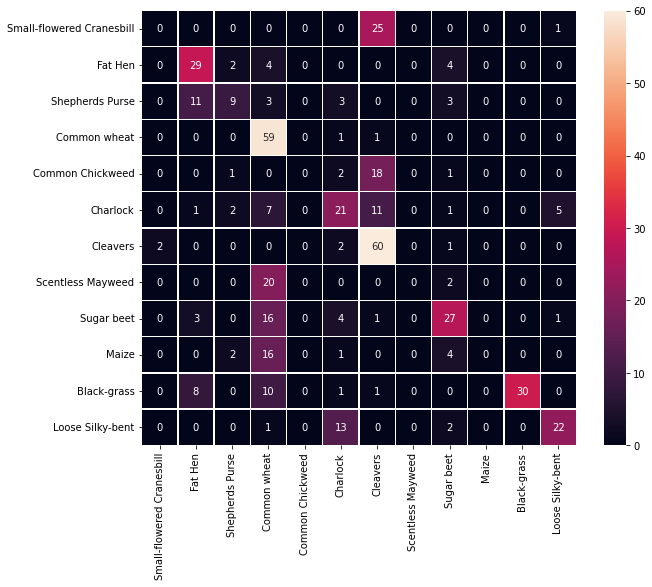

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg2=np.argmax(y_pred2,axis=1)
y_test_arg2=np.argmax(y_test_encoded,axis=1)
CATEGORIES= ["Small-flowered Cranesbill", "Fat Hen","Shepherds Purse", "Common wheat", "Common Chickweed","Charlock", "Cleavers", "Scentless Mayweed", "Sugar beet", "Maize", "Black-grass", "Loose Silky-bent"]
# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix2 = tf.math.confusion_matrix(y_test_arg2,y_pred_arg2)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix2,
    annot=True,
    xticklabels=CATEGORIES,
    yticklabels=CATEGORIES,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

#### **Observation**

Classes 0,4,7 and 9 are not classified at all. The performance of the model is has decreased with 128 * 128 images

In [ ]:

y_test_pred_classes_2 = np.argmax(y_pred2, axis=1)

from sklearn.metrics import accuracy_score, confusion_matrix

normal_y_test2 = np.argmax(y_test_encoded, axis=1)
accuracy_score(normal_y_test2, y_test_pred_classes_2)

0.5410526315789473

In [ ]:
print(classification_report((normal_y_test2), y_test_pred_classes_2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.56      0.74      0.64        39
           2       0.56      0.31      0.40        29
           3       0.43      0.97      0.60        61
           4       0.00      0.00      0.00        22
           5       0.44      0.44      0.44        48
           6       0.51      0.92      0.66        65
           7       0.00      0.00      0.00        22
           8       0.60      0.52      0.56        52
           9       0.00      0.00      0.00        23
          10       1.00      0.60      0.75        50
          11       0.76      0.58      0.66        38

    accuracy                           0.54       475
   macro avg       0.41      0.42      0.39       475
weighted avg       0.48      0.54      0.48       475



#### **Observation**

The recall score for class 3 and 6 are quite high which means a high fraction of relevant instances are being retrieved for these 2 classes. But at the same time the other classes are not performing well.

## **Model - 3. Data Augmentation with Batch Normalization on 64 pixel images**

In [69]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [70]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(
                              rotation_range=20, 
                              fill_mode='nearest',
                              horizontal_flip = True,
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1,  
                              shear_range = 0.1,
                              zoom_range=0.1
                              )

In [71]:
# Intializing a sequential model
model3 = Sequential()


model3.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model3.add(MaxPooling2D((2, 2), padding = 'same'))

model3.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model3.add(MaxPooling2D((2, 2), padding = 'same'))
model3.add(BatchNormalization())

model3.add(Conv2D(16, (3, 3), activation='relu', padding="same"))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model3.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.25))

model3.add(Dense(16, activation='relu'))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem  
model3.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
opt = SGD(learning_rate=0.01, momentum=0.9)

# Compile model
model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                        

#### **Observation**

The trainable parameters have increased with data sugmentation. The batch normalization has been added just after the max pooling layer

In [72]:
# Epochs
epochs = 15
# Batch size
batch_size = 64

history = model3.fit(train_datagen.flow(X_train64_normalized,y_train_encoded_64,
                                       batch_size=batch_size, 
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train64_normalized.shape[0] // batch_size,
                    validation_data=(X_val64_normalized, y_val_encoded_64),
                    verbose=1)

Epoch 1/15
60/60 [==============================] - 41s 668ms/step - loss: 2.3793 - accuracy: 0.1798 - val_loss: 2.4638 - val_accuracy: 0.1285
Epoch 2/15
60/60 [==============================] - 34s 565ms/step - loss: 1.9908 - accuracy: 0.2971 - val_loss: 2.4528 - val_accuracy: 0.2126
Epoch 3/15
60/60 [==============================] - 33s 546ms/step - loss: 1.7081 - accuracy: 0.3918 - val_loss: 3.7572 - val_accuracy: 0.1425
Epoch 4/15
60/60 [==============================] - 45s 744ms/step - loss: 1.6673 - accuracy: 0.4110 - val_loss: 6.6144 - val_accuracy: 0.1285
Epoch 5/15
60/60 [==============================] - 33s 545ms/step - loss: 1.4982 - accuracy: 0.4552 - val_loss: 4.4595 - val_accuracy: 0.1285
Epoch 6/15
60/60 [==============================] - 34s 562ms/step - loss: 1.4859 - accuracy: 0.4904 - val_loss: 5.9157 - val_accuracy: 0.1495
Epoch 7/15
60/60 [==============================] - 32s 529ms/step - loss: 1.3954 - accuracy: 0.5112 - val_loss: 2.4849 - val_accuracy: 0.2757

#### **Observation**

The accuracy on training dataset is achived till 0.611 while maximum accuracy on validation dataset is 0.50

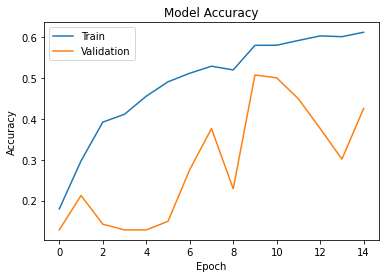

In [74]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [75]:
accuracy3 = model3.evaluate(X_test64_normalized, y_test_encoded_64, verbose=2)

15/15 - 1s - loss: 2.6736 - accuracy: 0.4126 - 895ms/epoch - 60ms/step


#### **Observation**

The accuracy on test dataset is quite low compared to training data

In [76]:
# Here we would get the output as probablities for each category
y_pred3=model3.predict(X_test64_normalized)

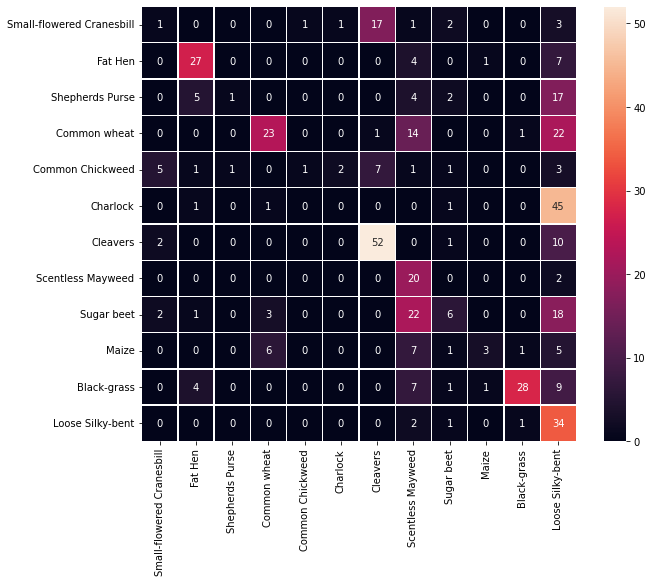

In [77]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg3=np.argmax(y_pred3,axis=1)
y_test_arg3=np.argmax(y_test_encoded_64,axis=1)
CATEGORIES= ["Small-flowered Cranesbill", "Fat Hen","Shepherds Purse", "Common wheat", "Common Chickweed","Charlock", "Cleavers", "Scentless Mayweed", "Sugar beet", "Maize", "Black-grass", "Loose Silky-bent"]

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix3 = tf.math.confusion_matrix(y_test_arg3,y_pred_arg3)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix3,
    annot=True,
    xticklabels=CATEGORIES,
    yticklabels=CATEGORIES,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()


In [79]:
y_test_pred_classes_3 = np.argmax(y_pred3, axis=1)

from sklearn.metrics import accuracy_score, confusion_matrix

normal_y_test3 = np.argmax(y_test_encoded_64, axis=1)


In [80]:
print(classification_report((normal_y_test3), y_test_pred_classes_3))

              precision    recall  f1-score   support

           0       0.10      0.04      0.06        26
           1       0.69      0.69      0.69        39
           2       0.50      0.03      0.06        29
           3       0.70      0.38      0.49        61
           4       0.50      0.05      0.08        22
           5       0.00      0.00      0.00        48
           6       0.68      0.80      0.73        65
           7       0.24      0.91      0.38        22
           8       0.38      0.12      0.18        52
           9       0.60      0.13      0.21        23
          10       0.90      0.56      0.69        50
          11       0.19      0.89      0.32        38

    accuracy                           0.41       475
   macro avg       0.46      0.38      0.33       475
weighted avg       0.49      0.41      0.38       475



#### **Observation**

Classes 1,6, 7 and 11 have good recall scores but precision and f1-score are very low. But this is not a good model as it overfitting on training data. The accuracy scores on validation data have been erratic, not consistent and there is a big gap between the training and validation set scores. Test data accuracy is also quite low. Batch normalization has not helped us to increase the accuracy. 

Let's try data augmentation with 128*128 images but without batch normalization

## **Model - 4. Data Augmentation without Batch Normalization on 128 pixel images**

In [120]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [123]:
# Intializing a sequential model
model4 = Sequential()

model4.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(128, 128, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model4.add(MaxPooling2D((2, 2), padding = 'same'))

model4.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model4.add(MaxPooling2D((2, 2), padding = 'same'))

model4.add(Conv2D(32, (3, 3), activation='relu', padding="same"))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model4.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model4.add(Dense(32, activation='relu'))
model4.add(Dropout(0.25))

model4.add(Dense(16, activation='relu'))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem  
model4.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
opt = SGD(learning_rate=0.01, momentum=0.9)

# Compile model
model4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 128)     3584      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 flatten_2 (Flatten)         (None, 32768)            

#### **Observation**

The trainable parameters have increased exponentially with data augmentation and with 128*128 images

In [124]:
# Epochs
epochs = 15
# Batch size
batch_size = 64

history_4 = model4.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size, 
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/15
60/60 [==============================] - 302s 5s/step - loss: 2.4519 - accuracy: 0.1380 - val_loss: 2.4276 - val_accuracy: 0.1379
Epoch 2/15
60/60 [==============================] - 291s 5s/step - loss: 2.4117 - accuracy: 0.1523 - val_loss: 2.4138 - val_accuracy: 0.1379
Epoch 3/15
60/60 [==============================] - 294s 5s/step - loss: 2.3815 - accuracy: 0.1758 - val_loss: 2.4078 - val_accuracy: 0.1402
Epoch 4/15
60/60 [==============================] - 291s 5s/step - loss: 2.3005 - accuracy: 0.2067 - val_loss: 2.1742 - val_accuracy: 0.2664
Epoch 5/15
60/60 [==============================] - 291s 5s/step - loss: 2.0856 - accuracy: 0.2591 - val_loss: 1.9480 - val_accuracy: 0.3364
Epoch 6/15
60/60 [==============================] - 297s 5s/step - loss: 1.9474 - accuracy: 0.3302 - val_loss: 1.8129 - val_accuracy: 0.3668
Epoch 7/15
60/60 [==============================] - 293s 5s/step - loss: 1.9119 - accuracy: 0.3302 - val_loss: 1.7572 - val_accuracy: 0.3832
Epoch 8/15
60

**Plotting Model accuracy against each epoch**

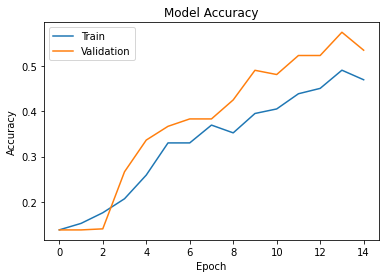

In [125]:
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### **Observation**

The model doesn't look overfitting on training data as the accuracy of Validation data is higher than training data. The maximum accuracy achieved on training data is 0.49 while for validation data its 0.574

**Plotting the Confusion Matrix**

In [127]:
# Here we would get the output as probablities for each category
y_pred4 = model4.predict(X_test_normalized)

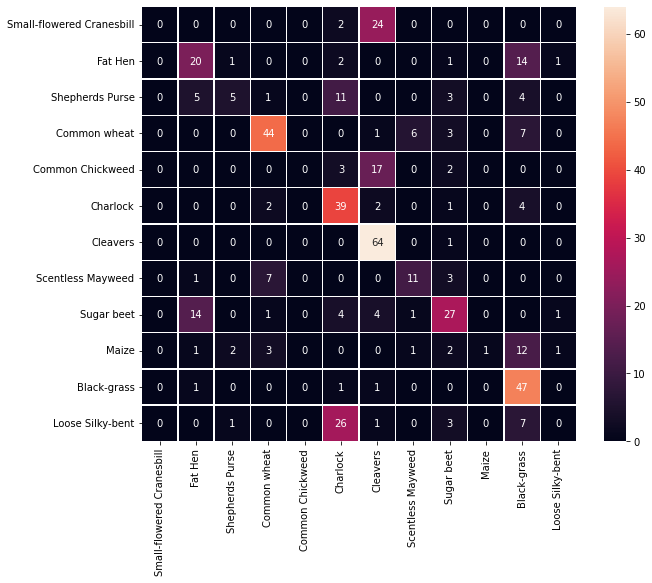

In [129]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg4 = np.argmax(y_pred4,axis=1)
y_test_arg4 = np.argmax(y_test_encoded,axis=1)
CATEGORIES= ["Small-flowered Cranesbill", "Fat Hen","Shepherds Purse", "Common wheat", "Common Chickweed","Charlock", "Cleavers", "Scentless Mayweed", "Sugar beet", "Maize", "Black-grass", "Loose Silky-bent"]
# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix4 = tf.math.confusion_matrix(y_test_arg4,y_pred_arg4)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix4,
    annot=True,
    xticklabels=CATEGORIES,
    yticklabels=CATEGORIES,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [130]:
y_test_pred_classes_4 = np.argmax(y_pred4, axis=1)

from sklearn.metrics import accuracy_score, confusion_matrix

normal_y_test4 = np.argmax(y_test_encoded, axis=1)
accuracy_score(normal_y_test4, y_test_pred_classes_4)

0.5431578947368421

#### **Observation**

The accuracy of test data is 0.54 is comparable to the validation set but its quite low. 'Cleavers' class is the most accurately predicted by the model

In [131]:
print(classification_report((normal_y_test4), y_test_pred_classes_4))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.48      0.51      0.49        39
           2       0.56      0.17      0.26        29
           3       0.76      0.72      0.74        61
           4       0.00      0.00      0.00        22
           5       0.44      0.81      0.57        48
           6       0.56      0.98      0.72        65
           7       0.58      0.50      0.54        22
           8       0.59      0.52      0.55        52
           9       1.00      0.04      0.08        23
          10       0.49      0.94      0.65        50
          11       0.00      0.00      0.00        38

    accuracy                           0.54       475
   macro avg       0.45      0.43      0.38       475
weighted avg       0.48      0.54      0.46       475



### **Observation**

Classes 3, 5, 6 and 10 have high recall scores but class 0,4 and 11 have not been classified by the model. 



##**Model 5 - Deeper model with more layers and different filter sizes**

In [95]:
# Clearing backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [96]:
# Intializing a sequential model
model5 = Sequential()

#Adding more layers to the model
model5.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

model5.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
# Adding max pooling to reduce the size of output of first conv layer
model5.add(MaxPooling2D((2, 2), padding = 'same'))

model5.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model5.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model5.add(MaxPooling2D((2, 2), padding = 'same'))

#Changing filter size 
model5.add(Conv2D(32, (2, 2), activation='relu', padding="same"))
model5.add(Conv2D(32, (2, 2), activation='relu', padding="same"))
model5.add(MaxPooling2D((2, 2), padding = 'same'))

model5.add(Conv2D(16, (2, 2), activation='relu', padding="same"))
model5.add(Conv2D(16, (2, 2), activation='relu', padding="same"))
model5.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model5.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model5.add(Dense(64, activation='relu'))
model5.add(Dropout(0.25))

model5.add(Dense(32, activation='relu'))
model5.add(Dense(16, activation='relu'))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem  
model5.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
opt = SGD(learning_rate=0.01, momentum=0.9)

# Compile model
model5.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                    

In [97]:
# Epochs
epochs = 10
# Batch size
batch_size = 64

history5 = model5.fit(train_datagen.flow(X_train64_normalized,y_train_encoded_64,
                                       batch_size=batch_size, 
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train64_normalized.shape[0] // batch_size,
                    validation_data=(X_val64_normalized, y_val_encoded_64),
                    verbose=1)

Epoch 1/10
60/60 [==============================] - 195s 2s/step - loss: 2.4637 - accuracy: 0.1213 - val_loss: 2.4401 - val_accuracy: 0.1285
Epoch 2/10
60/60 [==============================] - 131s 2s/step - loss: 2.4299 - accuracy: 0.1290 - val_loss: 2.4233 - val_accuracy: 0.1285
Epoch 3/10
60/60 [==============================] - 122s 2s/step - loss: 2.4203 - accuracy: 0.1311 - val_loss: 2.4189 - val_accuracy: 0.1379
Epoch 4/10
60/60 [==============================] - 120s 2s/step - loss: 2.4159 - accuracy: 0.1348 - val_loss: 2.4177 - val_accuracy: 0.1379
Epoch 5/10
60/60 [==============================] - 122s 2s/step - loss: 2.4175 - accuracy: 0.1383 - val_loss: 2.4173 - val_accuracy: 0.1379
Epoch 6/10
60/60 [==============================] - 127s 2s/step - loss: 2.4169 - accuracy: 0.1375 - val_loss: 2.4170 - val_accuracy: 0.1379
Epoch 7/10
60/60 [==============================] - 123s 2s/step - loss: 2.4158 - accuracy: 0.1295 - val_loss: 2.4169 - val_accuracy: 0.1379
Epoch 8/10
60

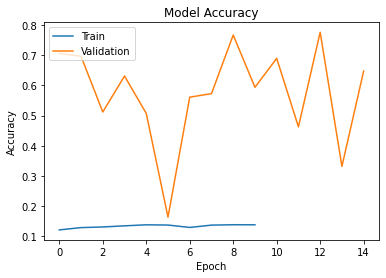

In [99]:
plt.plot(history5.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

####**Observation**

The training accuracy is very low while the validation accuracy is also not consistent. This model has not given a good result.

In [100]:
# Here we would get the output as probablities for each category
y_pred5=model5.predict(X_test64_normalized)

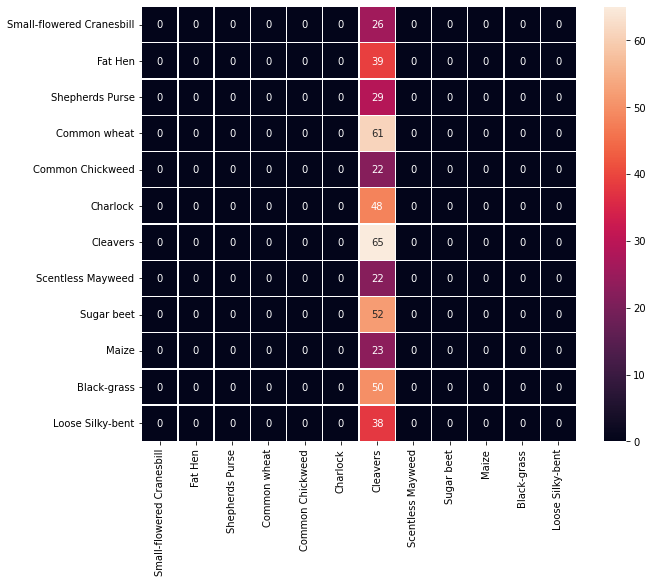

In [101]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg5=np.argmax(y_pred5,axis=1)
y_test_arg5=np.argmax(y_test_encoded_64,axis=1)
CATEGORIES= ["Small-flowered Cranesbill", "Fat Hen","Shepherds Purse", "Common wheat", "Common Chickweed","Charlock", "Cleavers", "Scentless Mayweed", "Sugar beet", "Maize", "Black-grass", "Loose Silky-bent"]

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix5 = tf.math.confusion_matrix(y_test_arg5,y_pred_arg5)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix5,
    annot=True,
    xticklabels=CATEGORIES,
    yticklabels=CATEGORIES,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [102]:
y_test_pred_classes_5 = np.argmax(y_pred5, axis=1)

from sklearn.metrics import accuracy_score, confusion_matrix

normal_y_test5 = np.argmax(y_test_encoded_64, axis=1)

In [103]:
print(classification_report((normal_y_test5), y_test_pred_classes_5))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        39
           2       0.00      0.00      0.00        29
           3       0.00      0.00      0.00        61
           4       0.00      0.00      0.00        22
           5       0.00      0.00      0.00        48
           6       0.14      1.00      0.24        65
           7       0.00      0.00      0.00        22
           8       0.00      0.00      0.00        52
           9       0.00      0.00      0.00        23
          10       0.00      0.00      0.00        50
          11       0.00      0.00      0.00        38

    accuracy                           0.14       475
   macro avg       0.01      0.08      0.02       475
weighted avg       0.02      0.14      0.03       475



####**Observation**
The model has given a very poor performance with most of the classes not classified at all. The test accuracy is also at a very low score of 14% only.

## **Model 6 - Transfer Learning using VGG16 Using Data Augmentation**

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

**Importing the VGG16 model for transfer learning and setting the parameters**

In [ ]:
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (128,128,3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

**Adding the fully connected layers to the VGG16 model**

In [ ]:
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
new_model.add(Flatten())

# Adding a dense output layer
new_model.add(Dense(32, activation='relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(16, activation='relu'))
new_model.add(Dense(12, activation='softmax'))
opt=Adam()
# Compile model
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 32)                262176    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 12)                204       
                                                                 
Total params: 14,977,596
Trainable params: 262,908
Non-t

**The trainable parameters have increased enormously. We will build the model for 15 epochs with data augmentation**

In [ ]:
# Epochs
epochs = 15
# Batch size
batch_size = 64

history_vgg16 = new_model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size, 
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)


Epoch 1/15
60/60 [==============================] - 629s 10s/step - loss: 2.3209 - accuracy: 0.2004 - val_loss: 2.1427 - val_accuracy: 0.2921
Epoch 2/15
60/60 [==============================] - 629s 10s/step - loss: 2.0730 - accuracy: 0.2910 - val_loss: 1.8951 - val_accuracy: 0.3855
Epoch 3/15
60/60 [==============================] - 625s 10s/step - loss: 1.8953 - accuracy: 0.3489 - val_loss: 1.7751 - val_accuracy: 0.3668
Epoch 4/15
60/60 [==============================] - 627s 10s/step - loss: 1.7573 - accuracy: 0.3788 - val_loss: 1.6093 - val_accuracy: 0.4603
Epoch 5/15
60/60 [==============================] - 629s 10s/step - loss: 1.6561 - accuracy: 0.4108 - val_loss: 1.5408 - val_accuracy: 0.4883
Epoch 6/15
60/60 [==============================] - 627s 10s/step - loss: 1.6010 - accuracy: 0.4171 - val_loss: 1.4388 - val_accuracy: 0.5093
Epoch 7/15
60/60 [==============================] - 635s 11s/step - loss: 1.5349 - accuracy: 0.4412 - val_loss: 1.4390 - val_accuracy: 0.4907
Epoch 

In [ ]:
accuracy = new_model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 71s - loss: 1.1996 - accuracy: 0.6063 - 71s/epoch - 5s/step


#### **Observation**
The test data has given us an accuracy of 0.606 which has been the highest among all the model made so far. Highest training accuracy achieved is 0.517 while highest accuracy achieved on validation set is 0.61

In [ ]:
y_test_pred_ln4 = new_model.predict(X_test_normalized)
y_test_pred_classes_ln4 = np.argmax(y_test_pred_ln4, axis=1)

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

normal_y_test = np.argmax(y_test_encoded, axis=1)
accuracy_score(normal_y_test, y_test_pred_classes_ln4)


0.6063157894736843

In [ ]:
labels['Label'].unique()

array(['Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse',
       'Common wheat', 'Common Chickweed', 'Charlock', 'Cleavers',
       'Scentless Mayweed', 'Sugar beet', 'Maize', 'Black-grass',
       'Loose Silky-bent'], dtype=object)

**Plotting the Confusion Matrix**

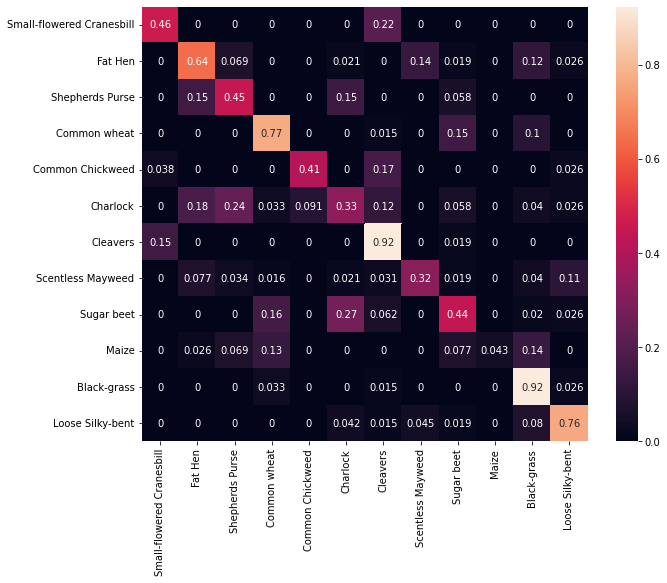

In [ ]:
cf_matrix = confusion_matrix(normal_y_test, y_test_pred_classes_ln4)

# Confusion matrix normalized per category true value
cf_matrix_n1 = cf_matrix/np.sum(cf_matrix, axis=1)
plt.figure(figsize=(10,8))

CATEGORIES= ["Small-flowered Cranesbill", "Fat Hen","Shepherds Purse", "Common wheat", "Common Chickweed","Charlock", "Cleavers", "Scentless Mayweed", "Sugar beet", "Maize", "Black-grass", "Loose Silky-bent"]
sns.heatmap(cf_matrix_n1, xticklabels=CATEGORIES, yticklabels=CATEGORIES, annot=True)

####**Observation**

We can observe that with the present model prediction on all classes has started. Classes 6 and 10 have been mostly predicted. 

In [ ]:
from sklearn.metrics import classification_report
print(classification_report((normal_y_test), y_test_pred_classes_ln4))

              precision    recall  f1-score   support

           0       0.71      0.46      0.56        26
           1       0.60      0.64      0.62        39
           2       0.52      0.45      0.48        29
           3       0.67      0.77      0.72        61
           4       0.82      0.41      0.55        22
           5       0.40      0.33      0.36        48
           6       0.59      0.92      0.72        65
           7       0.64      0.32      0.42        22
           8       0.51      0.44      0.47        52
           9       1.00      0.04      0.08        23
          10       0.63      0.92      0.75        50
          11       0.76      0.76      0.76        38

    accuracy                           0.61       475
   macro avg       0.65      0.54      0.54       475
weighted avg       0.63      0.61      0.58       475



#### **Observation**
The recall score, precition and f1-score for many of the classes have improved. The accuracy of the model has also increased on test data. 

###**Conclusion**

We can observe from the confusion matrix of all the models that VGG16 model was the best model because it predicted the majority of the classes better than the other models.
The test accuracy of the VGG16 model is 60%.
Data Augmentation has also helped in improving the model.



###**Comparing the test accuracy of all 6 models**

In [105]:
pd.DataFrame({'Models':['CNN Model-64*64','CNN Model-128*128','CNN Model with DA and BN-64*64', 'CNN Model with DA and no BN-128*128','Deep CNN Model with different filters','Transfer Learning Model'],'Train Accuracy':['56.6%','47%','61.1%','49%','13.8%','51.7%'],'Validation Accuracy':['61%','54%','50%','57%','13%','61%'],'Test Accuracy':['54%','54%','41%','54.3%','14%','60%']})

,Models,Train Accuracy,Validation Accuracy,Test Accuracy
0,CNN Model-64*64,56.6%,61%,54%
1,CNN Model-128*128,47%,54%,54%
2,CNN Model with DA and BN-64*64,61.1%,50%,41%
3,CNN Model with DA and no BN-128*128,49%,57%,54.3%
4,Deep CNN Model with different filters,13.8%,13%,14%
5,Transfer Learning Model,51.7%,61%,60%


##**Analysis and Scope of Improvement**

1. From the above results we can observe that VGG16 model has given us the best consistent scores on all datasets.

2. We can improve on the Transfer learning model with better higher convolution layers which can detect the weed leaves on a higher level.

3. We can also add more filters of different sizes to get more accurate results

4. Many of the pictures in the original dataset are not clear hence steps could be taken to improve the picture clarity

5. We can perform more data augmentation and drop out rates can be changed.

6. We can also try other transfer learning models to check the performance.

